In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import KFold 

In [9]:

# print(np.zeros(100))
dataTrain=pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\WorkSem3\\CS215\\assignment3\\cs-215-assignment-3-multiple-variate-regression\\train.csv')
numSamples,features=dataTrain.shape[0],dataTrain.shape[1]-2
x_train=dataTrain.iloc[:,1:-1].values
y_train=dataTrain.iloc[:,-1].values
print(x_train.shape[0])
print(dataTrain)

15000


In [10]:
def KernelRegression(X_train,Y_train,X_test,bandwidth):
    Y_pred = np.zeros(X_test.shape[0])
    
    for i in range(X_test.shape[0]):
        distances = np.linalg.norm(X_train - X_test[i], axis=1)
        weights = gaussian_kernel(distances, bandwidth)
        weights_sum = np.sum(weights)
        
        if weights_sum > 0:
            Y_pred[i] = np.sum(weights * Y_train) / weights_sum
        else:
            Y_pred[i] = np.mean(Y_train)
    
    return Y_pred

def OLS(X,Y):
    X_b=np.concatenate([np.ones((X.shape[0],1)),X],axis=1)
    beta=np.linalg.inv((X_b.T).dot(X_b)).dot(X_b.T).dot(Y)
    return beta

def gaussian_kernel(distance, bandwidth):
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

# def Kfold(x, y, bandwidth,p=750):
#     #Under Kfold we leave out k samples to validate are learning from rest 
#     #of the training samples and then keep doing this the whole sample
#     errors = []
    
#     for i in range(numSamples):
#         idx_val = np.arange(i,min(i+p,numSamples))
#         i=i+p
#         idx_val=idx_val.astype(int)
#         idx_train = np.delete(np.arange(numSamples), idx_val)
#         x_train, y_train = x.iloc[idx_train], y.iloc[idx_train]
#         x_val, y_val = x.iloc[idx_val], y.iloc[idx_val]
#         y_pred = np.array([KernelRegression(x_train, y_train, x_v, bandwidth) for x_v in x_val])
        
#         error = np.mean((y_pred - y_val) ** 2)
#         errors.append(error)
#     return np.mean(errors)

def mean_absolute_error(Y_true, Y_pred):
    return np.mean(np.abs(Y_true - Y_pred))

bandwidth = 1.0  # You can tune this
beta_ols = OLS(x_train, y_train)
print("OLS Coefficients:", beta_ols)

OLS Coefficients: [-2.76404705e+03  6.14588182e-03 -1.49178606e+00  2.37551314e+00
  8.75568393e+01  2.50217691e+01  9.09304413e+01  5.92649249e+03
  5.53468466e+03 -6.82049253e+02 -1.60335932e+01 -2.48950823e+04
 -1.44143525e+01  4.77793761e+00 -5.10292525e+02  1.28154103e+04
 -1.37514176e+03  8.50667650e+01]


In [11]:
Y_pred_kernel = KernelRegression(x_train, y_train, x_train, bandwidth)

# Compute MAE for OLS predictions (using X_train as example)
Y_pred_ols = np.dot(np.c_[np.ones((x_train.shape[0], 1)), x_train], beta_ols)
mae_ols = mean_absolute_error(y_train, Y_pred_ols)

# Compute MAE for kernel regression
mae_kernel = mean_absolute_error(y_train, Y_pred_kernel)

In [12]:
print("MAE for OLS:", mae_ols)

print("MAE for Kernel Regression:", mae_kernel)

MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 161.35104670556908


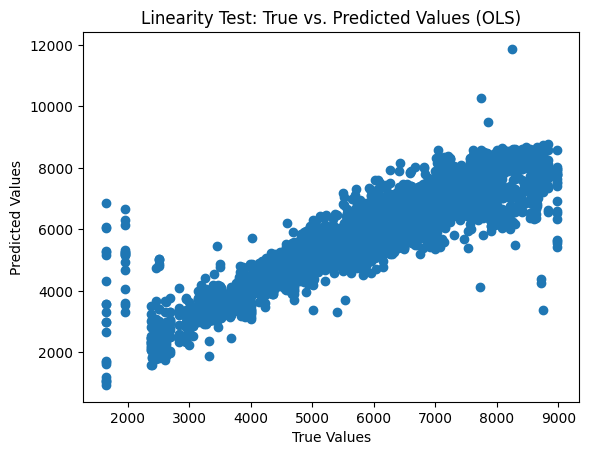

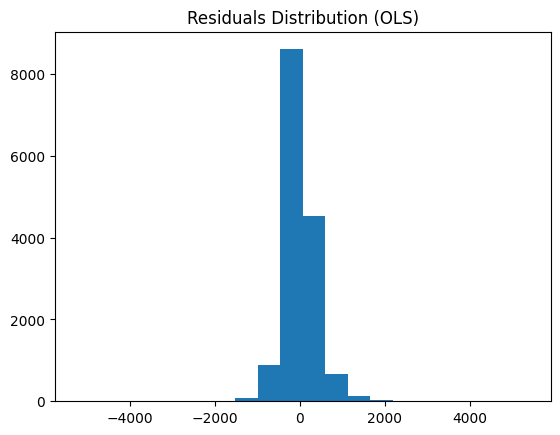

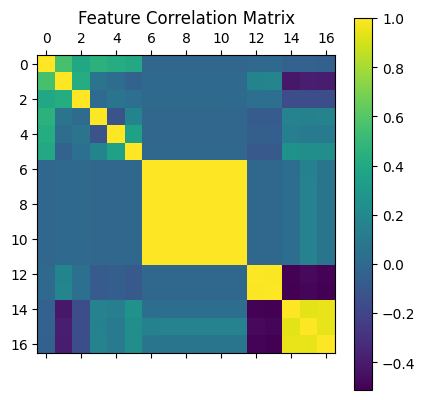

In [13]:
plt.scatter(y_train, Y_pred_ols)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linearity Test: True vs. Predicted Values (OLS)")
plt.show()

residuals_ols = y_train - Y_pred_ols
plt.hist(residuals_ols, bins=20)
plt.title("Residuals Distribution (OLS)")
plt.show()

correlation_matrix = pd.DataFrame(x_train).corr()
plt.matshow(correlation_matrix)
plt.title("Feature Correlation Matrix")
plt.colorbar()
plt.show()



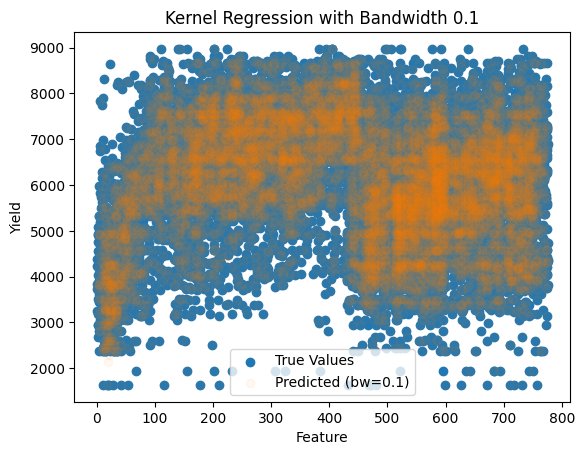

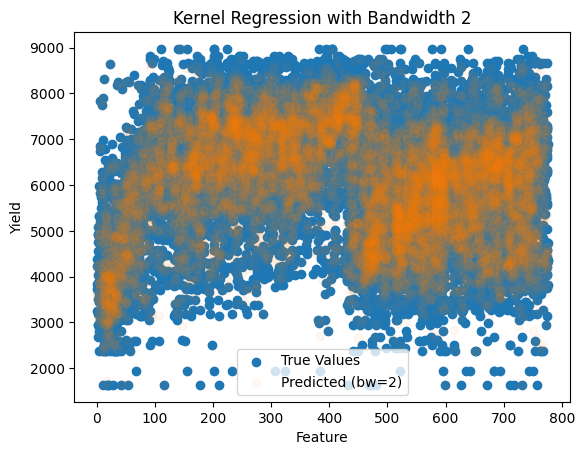

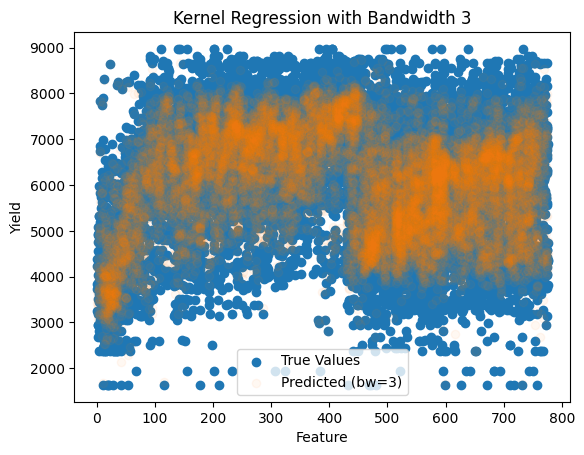

In [14]:

bws = [0.1, 2, 3]
for bw in bws:
    Y_pred_bw = KernelRegression(x_train, y_train, x_train, bw)
    plt.scatter(x_train[:, 0], y_train, label="True Values")
    plt.scatter(x_train[:, 0], Y_pred_bw, label=f"Predicted (bw={bw})",alpha=0.05)
    plt.xlabel("Feature")
    plt.ylabel("Yield")
    plt.title(f"Kernel Regression with Bandwidth {bw}")
    plt.savefig(f"TrueYieldVsPredBW={bw}.png")
    plt.legend()
    plt.show()

In [21]:
def crossValidation(X,Y,bandwidths,k=1500):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_errors = np.zeros(len(bandwidths))

    # For each fold
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        
        # Test for each bandwidth
        for i, bandwidth in enumerate(bandwidths):
            Y_pred_val = KernelRegression(X_train, Y_train, X_val, bandwidth)
            cv_errors[i] += mean_absolute_error(Y_val, Y_pred_val)
    
    # Compute the average error for each bandwidth
    cv_errors /= k
    best_bandwidth_index = np.argmin(cv_errors)
    best_bandwidth = bandwidths[best_bandwidth_index]
    
    return best_bandwidth, cv_errors

In [22]:
def crossValidation_wrong(X,Y,bandwidths,k=1500):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_errors = np.zeros(len(bandwidths))

    # For each bandwidth
    for i, bandwidth in enumerate(bandwidths):
        # Test for each fold
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            Y_train, Y_val = Y[train_index], Y[val_index]
            Y_pred_val = KernelRegression(X_train, Y_train, X_val, bandwidth)
            cv_errors[i] += mean_absolute_error(Y_val, Y_pred_val)
    
    # Compute the average error for each bandwidth
    cv_errors /= len(kf.split(X)[:,0])
    best_bandwidth_index = np.argmin(cv_errors)
    best_bandwidth = bandwidths[best_bandwidth_index]
    
    return best_bandwidth, cv_errors

In [23]:
bandwidths = np.linspace(1, 4, 20)  # 10 bandwidth values between 0.1 and 2.0

# Find the best bandwidth using cross-validation
best_bandwidth, cv_errors = crossValidation(x_train, y_train, bandwidths,1500)

# Visualize Kernel Regression predictions for best bandwidth
Y_pred_kernel_best = KernelRegression(x_train, y_train, x_train, best_bandwidth)

mae_kernel_opt = mean_absolute_error(y_train, Y_pred_kernel_best)

In [19]:
# Compute MAE for OLS predictions (using X_train as example)
Y_pred_ols = np.dot(np.c_[np.ones((x_train.shape[0], 1)), x_train], beta_ols)
mae_ols = mean_absolute_error(y_train, Y_pred_ols)

bandwidths=[2,3,1.58,4,5,1]
for bandwidth in bandwidths:
    print(f'bandwidth:{bandwidth}')
    Y_pred_kernel = KernelRegression(x_train, y_train, x_train, bandwidth)

    # Compute MAE for kernel regression
    mae_kernel = mean_absolute_error(y_train, Y_pred_kernel)
    print("MAE for OLS:", mae_ols)

    print("MAE for Kernel Regression:", mae_kernel)

bandwidth:2
MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 295.7370331746493
bandwidth:3
MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 409.03861410484865
bandwidth:1.58
MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 243.43643199851886
bandwidth:4
MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 500.468130272286
bandwidth:5
MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 571.5408496901698
bandwidth:1
MAE for OLS: 269.5974200305067
MAE for Kernel Regression: 161.35104670556908


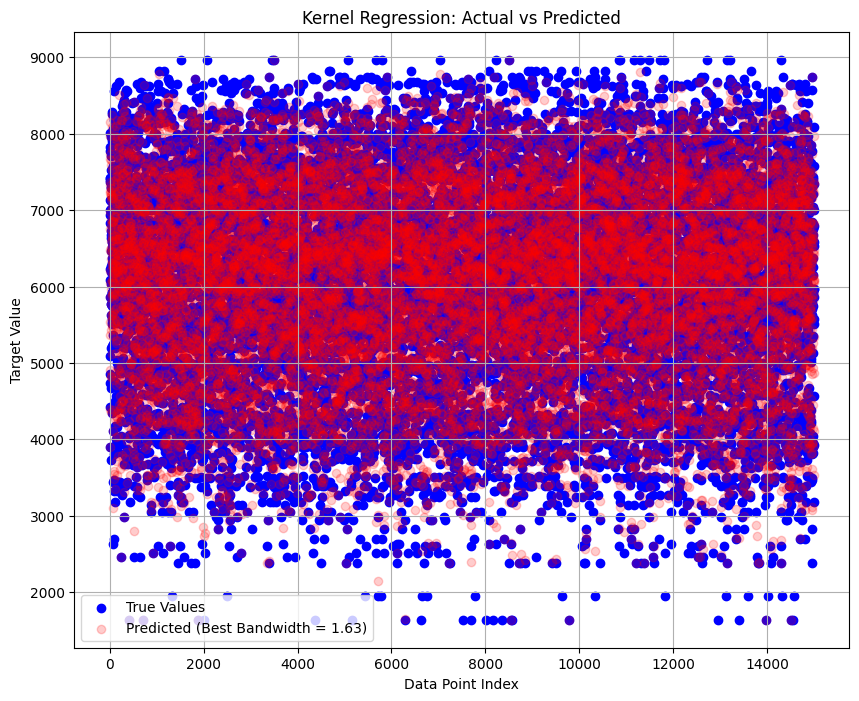

MAE for Kernel Regression At optimal bandwidth: 250.07089055368243
Best Bandwidth Is  1.631578947368421
Cross Validation Errors:  [510.53729212 502.56028969 497.16833279 494.16762777 493.3967551
 494.54020507 497.56569574 502.36049397 508.36003447 515.20161039
 522.71564288 530.63635532 538.75426403 546.84956437 554.87300925
 562.82158521 570.60667475 578.20385534 585.6300492  592.92535508]


In [31]:
# Plot Actual vs Predicted for Kernel Regression
plt.figure(figsize=(10,8))
plt.scatter(np.arange(numSamples),y_train, label="True Values", marker='o', color='b')
plt.scatter(np.arange(numSamples),Y_pred_kernel_best, label=f"Predicted (Best Bandwidth = {best_bandwidth:.2f})", marker='o', color='r',alpha=0.2)
plt.title('Kernel Regression: Actual vs Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()


mae_kernel=mean_absolute_error(y_train,Y_pred_kernel_best)
print("MAE for Kernel Regression At optimal bandwidth:", mae_kernel)
print("Best Bandwidth Is ",best_bandwidth)
print("Cross Validation Errors: ",cv_errors)


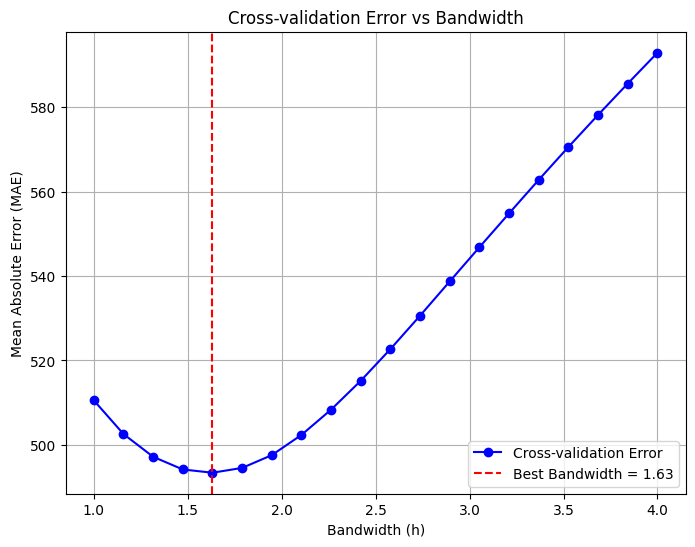

In [25]:
# Plot Cross-validation Error vs Bandwidth
plt.figure(figsize=(8, 6))
plt.plot(bandwidths, cv_errors, marker='o', color='b', label="Cross-validation Error")
plt.axvline(x=best_bandwidth, color='r', linestyle='--', label=f'Best Bandwidth = {best_bandwidth:.2f}')
plt.title('Cross-validation Error vs Bandwidth')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
testing=pd.read_csv('C:\\Users\\HP\\OneDrive\\Desktop\\DAI_assignment\\assignment-3\\5\\cs-215-assignment-3-multiple-variate-regression\\test.csv')
x_test=testing.iloc[:,1:].values
# print(x_test)

[[4.82000000e+02 2.50000000e+01 5.00000000e-01 ... 4.24574228e-01
  4.17908804e-01 3.14484199e+01]
 [2.90000000e+02 1.25000000e+01 2.50000000e-01 ... 5.52359420e-01
  4.76308423e-01 3.84173944e+01]
 [3.00000000e+01 2.50000000e+01 2.50000000e-01 ... 5.11413154e-01
  4.45494390e-01 3.54870084e+01]
 ...
 [4.78000000e+02 2.50000000e+01 5.00000000e-01 ... 5.89622441e-01
  4.87427885e-01 4.08131810e+01]
 [1.65000000e+02 1.25000000e+01 2.50000000e-01 ... 5.93029845e-01
  4.94895461e-01 4.19718161e+01]
 [7.36000000e+02 2.50000000e+01 5.00000000e-01 ... 3.88956310e-01
  3.96043550e-01 2.93885602e+01]]


In [34]:
def make_pred():
    Y_pred=KernelRegression(x_train,y_train,x_test,best_bandwidth)
    return Y_pred


prediction=make_pred()

In [37]:


def writeCSV():
    # print(prediction.shape)
    id_col=testing.iloc[:,0].rename("id")
    yield_col=pd.Series(prediction[:], name="yield")
    combined_df=pd.concat([id_col,yield_col],axis=1)
    print(combined_df)
    combined_df.to_csv("pred.csv", index=False)
    pass
    # pred_test_df = test_data[['id']]
    # x_test=test_data.iloc[:,1:].values
    # Y_pred_kernel_best_test = KernelRegression(x_train, y_train, x_test, best_bandwidth).reshape(-1,1)
    # pred_test_df['yield'] = Y_pred_kernel_best_test
    # pred_test_df.to_csv('test_predicted_kernel.csv')
writeCSV()

         id        yield
0     15000  4380.567898
1     15001  6837.811175
2     15002  4825.136302
3     15003  6498.740958
4     15004  5624.969897
...     ...          ...
9995  24995  7511.878799
9996  24996  4577.225570
9997  24997  7347.470959
9998  24998  7776.320070
9999  24999  4459.920008

[10000 rows x 2 columns]
